In [19]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.ToTensor()

In [3]:
train_dataset = torchvision.datasets.MNIST(root = "./data" , train = True , download = True , transform = transform)
valid_dataset = torchvision.datasets.MNIST(root = "./data" , train = False , download = True , transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_dl = torch.utils.data.DataLoader(train_dataset , batch_size = 100)

In [5]:
class Encoder(nn.Module):
    def __init__(self , hidden_size1 = 32*3*3 , hidden_size2 = 128 , z_dim = 4):
        super().__init__()
        #100 , 1 , 28 , 28
        self.conv1 = nn.Conv2d(1 , 8 , 3 , stride = 2 , padding = 1)
        #100 , 8 , 14 , 14
        self.conv2 = nn.Conv2d(8 , 16 , 3 , stride = 2 , padding = 1)
        #100 , 16 , 7 , 7
        self.conv3 = nn.Conv2d(16 , 32 , 3 , stride = 2 , padding = 0)
        #100 , 32 , 3 , 3
        self.fc1 = nn.Linear(32 * 3 * 3 , 128)
        self.fc2 = nn.Linear(128 , z_dim)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.bn(x)
        x = self.relu(self.conv3(x))
        x = x.flatten(1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self , z_dim = 4):
        super().__init__()
        self.fc3 = nn.Linear(z_dim , 128)
        self.fc4 = nn.Linear(128 , 32*3*3)
        self.t_conv1 = nn.ConvTranspose2d(32 , 16 , 3 , stride = 2 , output_padding = 0)
        self.bn2 = nn.BatchNorm2d(16)
        self.t_conv2 = nn.ConvTranspose2d(16 , 8 , 3 , stride = 2 , padding = 1 , output_padding = 1)
        self.bn3 = nn.BatchNorm2d(8)
        self.t_conv3 = nn.ConvTranspose2d(8 , 1 , 3 , stride = 2 , padding = 1 , output_padding = 1)
        self.relu = nn.ReLU()
    def forward(self , x):
        #x = 100 , 4
        x = self.relu(self.fc3(x))
        #100 , 128
        x = self.relu(self.fc4(x))
        #100 , 32*3*3
        x = x.unflatten(1 , (32 , 3 , 3))
        #x = 100 , 32 , 3 , 3
        x = self.t_conv1(x)
        #x = 100 , 16 , 7 , 7
        x = self.bn2(x)
        x = self.relu(x)
        x = self.t_conv2(x)
        #x = 100 , 8 , 14 , 14
        x = self.bn3(x)
        x = self.relu(x)
        x = self.t_conv3(x)
        #x = 100 , 1 , 28 , 28
        x = torch.sigmoid(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [9]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

In [10]:
train_loss = []

In [11]:
num_epochs = 30

In [12]:
for epoch in range(num_epochs):
    train_epoch_loss = 0
    for (imgs , _) in train_dl:
        imgs = imgs.to(device)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output , imgs)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)

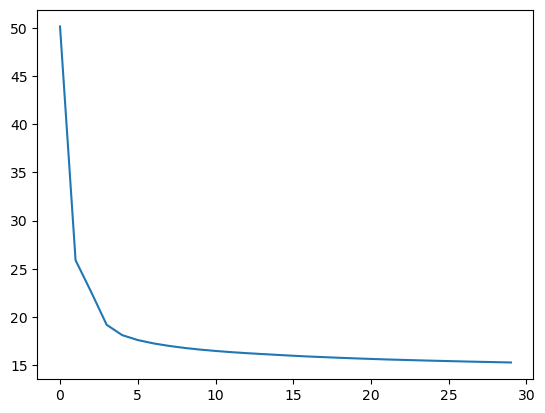

In [15]:
plt.plot(train_loss)

In [17]:
values = None
all_labels = []
with torch.no_grad():
    for (imgs , labels) in train_dl:
        imgs = imgs.to(device)
        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if values is None:
            values = latents.cpu()
        else:
            values = torch.vstack([values , latents.cpu()])

In [18]:
values.shape , len(all_labels)

(torch.Size([60000, 4]), 60000)

In [26]:
all_means = {}
all_labels = np.array(all_labels)
for i in range(10):
    inds = np.argwhere(all_labels == i)
    num_latents = values[inds].squeeze().numpy()
    mean = num_latents.mean(axis = 0)
    all_means[i] = mean

In [30]:
torch.Tensor(all_means[0])[None , ...].shape

torch.Size([1, 4])

In [44]:
with torch.no_grad():
    pred = dec(torch.Tensor(all_means[9])[None , ...].to(device)).cpu()
transforms.ToPILImage()(pred.squeeze(0))

In [34]:
pred.squeeze(0).shape

torch.Size([1, 28, 28])

In [35]:
transforms.ToPILImage()(pred.squeeze(0))

In [13]:
#nn.ConvTranspose2d(8 , 1 , 3 , stride = 2 , padding = 1 , output_padding = 1)(torch.randn(100 , 8 , 14 , 14)).shape